 > # AI Image Caption Bot 

# Steps:
- data collection
- understanding the data
- data cleaning
- loading the training set
- data preprocessing for images and captions
- data preparation using generator function
- word embeddings
- model architecture
- inference
- evaluation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [0]:
from PIL import Image, ImageFont, ImageDraw

In [0]:
# read the captions
def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    return captions
    

In [4]:
captions = readTextFile("/content/drive/My Drive/Flickr_Data.zip (Unzipped Files)/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
#total number of captions
print(len(captions.split("\n")))
captions=captions.split("\n")[:-1] #discard last line as it is empty
print(len(captions))

40461
40460


In [5]:
captions[0]  #image_id #caption_id caption

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [6]:
first, second= captions[0].split('\t') #separates image caption and image id 
print(first.split("."))
print(first.split(".")[0])#image_id
print(second)#caption

['1000268201_693b08cb0e', 'jpg#0']
1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [0]:
# after reading the data we make a dictionary to map every image with list of captions it corresponds to

descriptions= {}

for x in captions:
    first, second= x.split('\t')
    img_name=first.split(".")[0]
    
    #check if image_id is already present or not, insert key value pairs
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
        
    descriptions[img_name].append(second)

In [8]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

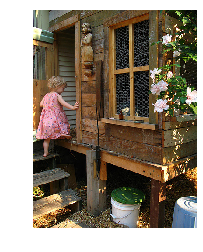

In [95]:
IMG_PATH="/content/drive/My Drive/Flickr_Data.zip (Unzipped Files)/Flickr_Data/Images/"
import cv2
import matplotlib.pyplot as plt

img=cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

# Text Cleaning

In [0]:
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    
    #remove the words with length 1
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence

In [11]:
clean_text("a dog is sitting on the box number 123")

'dog is sitting on the box number'

In [0]:
# call clean_text for all the captions
for key,captions_list in descriptions.items():
    for i in range(len(captions_list)):
        captions_list[i]=clean_text(captions_list[i])

In [13]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [0]:
#copy the data to a text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

# Create The Vocab

In [0]:
#load data from the text file
descriptions=None
with open("descriptions_1.txt","r") as f:
    descriptions=f.read()
    
json_acceptable_string= descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)

In [16]:
print(type(descriptions))

<class 'dict'>


In [17]:
vocab= set() #stores unique words
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]#for evry sentence mapped with a key i.e caption
                  
print("Vocab size is %d"%len(vocab))

Vocab size is 8424


In [18]:
# total number of words
total_words=[]

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("total words are %d"%len(total_words))

total words are 373837


In [19]:
print(total_words[:30])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl', 'going', 'into', 'wooden', 'building', 'little', 'girl', 'climbing', 'into', 'wooden', 'playhouse', 'little', 'girl', 'climbing', 'the', 'stairs']


In [0]:
# filter the words from the vocab acc to a threshold value

In [21]:
import collections
counter=collections.Counter(total_words)
freq_cnt=dict(counter)
#print(freq_cnt)
print(len(freq_cnt))

8424


In [0]:
# sort the dict acc to frequency count
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
threshold=10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt]

In [23]:
#sorted_freq_cnt
#total_words
print(len(total_words))

1845


In [0]:
train_file_data=readTextFile("/content/drive/My Drive/Flickr_Data.zip (Unzipped Files)/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data=readTextFile("/content/drive/My Drive/Flickr_Data.zip (Unzipped Files)/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [0]:
#make a list of train_file
train=[row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test=[row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [26]:
print(train[:10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']


In [0]:
#add <s> and <e> to training data
train_descriptions={}

for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append= "startseq " +cap+ " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [28]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Image Feature Extraction

In [0]:
# use a pre trained model---resnet50

In [30]:
model =ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()








102858752/102853048 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_________________

In [0]:
# to extract features from images we do not take the last layer 
#create a new model for feature extraction
# model_new is resnet50 conv base
model_new=Model(model.input,model.layers[-2].output)#pass input and output layer

In [0]:
#extract image feature vectors
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    #normalization
    img=preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


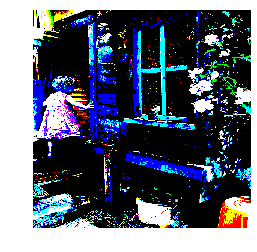

[[[[ -30.939003   -61.779      -67.68     ]
   [  13.060997     6.2210007  -17.68     ]
   [  34.060997    32.221        5.3199997]
   ...
   [ -99.939     -116.779     -118.68     ]
   [ -98.939     -111.779     -118.68     ]
   [-101.939     -108.779     -120.68     ]]

  [[ -36.939003   -68.779      -72.68     ]
   [  21.060997     9.221001   -13.68     ]
   [  38.060997    37.221        8.32     ]
   ...
   [ -94.939     -104.779     -113.68     ]
   [ -93.939     -108.779     -116.68     ]
   [ -90.939      -86.779     -102.68     ]]

  [[ -39.939003   -74.779      -76.68     ]
   [  26.060997    13.221001    -9.68     ]
   [  41.060997    36.221        6.3199997]
   ...
   [ -99.939     -107.779     -115.68     ]
   [-101.939     -107.779     -121.68     ]
   [ -95.939     -101.779     -123.68     ]]

  ...

  [[ -27.939003    56.221      107.32     ]
   [ -92.939      -49.779       20.32     ]
   [ -49.939003   -13.778999    35.32     ]
   ...
   [ 150.061      132.22101    126.

In [33]:
IMG_PATH="/content/drive/My Drive/Flickr_Data.zip (Unzipped Files)/Flickr_Data/Images/"
img=preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()
print(img)

In [0]:
def encode_img(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)
    feature_vector=feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [35]:
encode_img(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.04154305, 0.17076026, 0.29278535, ..., 0.05089615, 0.3132236 ,
       0.8600748 ], dtype=float32)

In [58]:
start=time()
encoding_train={}
#image_id--> feature vector extracted from resnet image

for ix,img_id in enumerate(train):
    img_path=IMG_PATH+ "/"+img_id+ ".jpg"
    encoding_train[img_id]= encode_img(img_path)
    
    if ix%100==0:
        print("encoding in process time step %d"%ix)
        
end_t=time()
print("total time taken :", end_t-start)
    

encoding in process time step 0
encoding in process time step 100
encoding in process time step 200
encoding in process time step 300
encoding in process time step 400
encoding in process time step 500
encoding in process time step 600
encoding in process time step 700
encoding in process time step 800
encoding in process time step 900
encoding in process time step 1000
encoding in process time step 1100
encoding in process time step 1200
encoding in process time step 1300
encoding in process time step 1400
encoding in process time step 1500
encoding in process time step 1600
encoding in process time step 1700
encoding in process time step 1800
encoding in process time step 1900
encoding in process time step 2000
encoding in process time step 2100
encoding in process time step 2200
encoding in process time step 2300
encoding in process time step 2400
encoding in process time step 2500
encoding in process time step 2600
encoding in process time step 2700
encoding in process time step 28

In [0]:
#store it to a disk
with open("train_features.pkl","wb") as f:
  pickle.dump(encoding_train,f)

In [60]:
start=time()
encoding_test={}
#image_id--> feature vector extracted from resnet image

for ix,img_id in enumerate(test):
    img_path=IMG_PATH+ "/"+img_id+ ".jpg"
    encoding_test[img_id]= encode_img(img_path)
    
    if ix%100==0:
        print("test encoding in process time step %d"%ix)
        
end_t=time()
print("total time taken(test) :", end_t-start)

test encoding in process time step 0
test encoding in process time step 100
test encoding in process time step 200
test encoding in process time step 300
test encoding in process time step 400
test encoding in process time step 500
test encoding in process time step 600
test encoding in process time step 700
test encoding in process time step 800
test encoding in process time step 900
total time taken(test) : 540.1503865718842


In [0]:
#store it to a disk
with open("test_features.pkl","wb") as f:
  pickle.dump(encoding_test,f)

In [115]:
d=encoding_train.get("2513260012_03d33305cf")
print(d)

[0.28047323 0.40687522 0.0837999  ... 0.9107925  0.04341797 0.09577909]


In [0]:
default = '1000268201_693b08cb0e.jpg'
a = encoding_train.get('2513260012_03d33305cf.jpg', default)

# Data preprocessing for captions

In [36]:
len(total_words)

1845

In [0]:
word_to_idx={}
idx_to_word={}

for i,word in enumerate(total_words):
  word_to_idx[word]=i+1
  idx_to_word[i+1]=word

In [64]:
print(word_to_idx["dog"])
print(idx_to_word[6])

6
dog


In [65]:
print(len(word_to_idx))

1845


In [66]:
#we have to add startseq and endseq manually to our dataset
idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846

idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847

vocab_size=len(word_to_idx)+1
print("Vocab size",vocab_size)

Vocab size 1848


In [67]:
max_len=0
for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    max_len=max(max_len,len(cap.split()))
    
print(max_len)

35


In [0]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []
    n=0
    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0
        

In [113]:
d=encoding_train.get("2513260012_03d33305cf.jpg")
print(d)

None


# Word Embedding

In [0]:
f= open('/content/drive/My Drive/glove.6B.50d.txt',encoding='utf8')

In [0]:
embedding_index={}

for line in f:
  values=line.split()
  word=values[0]
  word_embedding=np.array(values[1:],dtype='float')
  embedding_index[word]=word_embedding

In [0]:
f.close()

In [72]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [0]:
def get_emmbedding_matrix():
  emb_dim=50
  matrix=np.zeros((vocab_size,emb_dim))
  for word,idx in word_to_idx.items():
    embedding_vector=embedding_index.get(word)
    
    if embedding_vector is not None:
      matrix[idx] = embedding_vector
      
  return matrix

In [74]:
embedding_matrix=get_emmbedding_matrix()
embedding_matrix.shape

(1848, 50)

# Model Architecture

In [0]:
# image feature extractor model
input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [0]:
# partial caption sequence model
input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [0]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [108]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 35, 50)       92400       input_7[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_6[0][0]                    
____________________________________________________________________________________________

In [0]:
#pre initialise the embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

# Train our model

In [0]:
epochs = 20
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [118]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('models.h5')

Epoch 1/1
2000/2000 [==============================] - 154s 77ms/step - loss: 3.5856
Epoch 1/1
2000/2000 [==============================] - 151s 75ms/step - loss: 3.3272
Epoch 1/1
2000/2000 [==============================] - 150s 75ms/step - loss: 3.1680
Epoch 1/1
2000/2000 [==============================] - 149s 74ms/step - loss: 3.0563
Epoch 1/1
2000/2000 [==============================] - 149s 75ms/step - loss: 2.9685
Epoch 1/1
2000/2000 [==============================] - 149s 74ms/step - loss: 2.9015
Epoch 1/1
2000/2000 [==============================] - 149s 75ms/step - loss: 2.8428
Epoch 1/1
2000/2000 [==============================] - 148s 74ms/step - loss: 2.7979
Epoch 1/1
2000/2000 [==============================] - 148s 74ms/step - loss: 2.7567
Epoch 1/1
2000/2000 [==============================] - 148s 74ms/step - loss: 2.7219
Epoch 1/1
2000/2000 [==============================] - 149s 74ms/step - loss: 2.6902
Epoch 1/1
2000/2000 [==============================] - 150s 75ms/

In [0]:
model = load_model("models.h5")

# Predictions


In [0]:
# Load the test images features from disk
with open("/content/test_features.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [0]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()#word with maximum probability
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()[1:-1]
    #final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

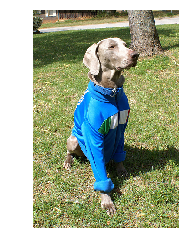

little girl in purple sweater is playing with toy


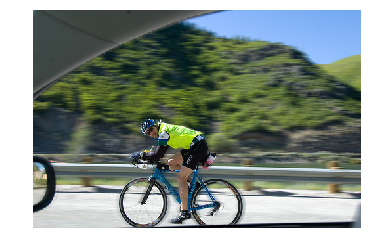

man in green shirt is riding his bike on dirt track


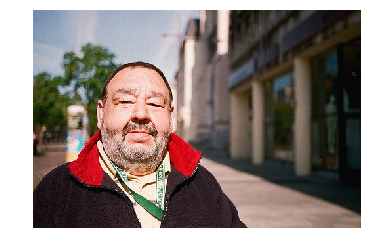

man in black hat and jean jacket is sitting on the street


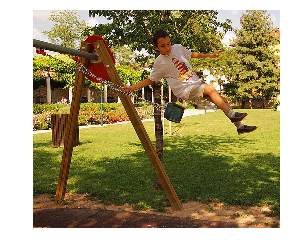

boy in red shirt and blue jeans is swinging on swing


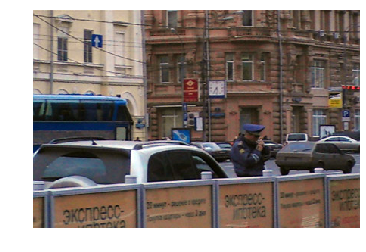

the man is waiting to cross the street


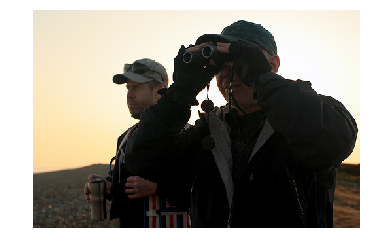

man in black shirt and tie hat stands next to the street


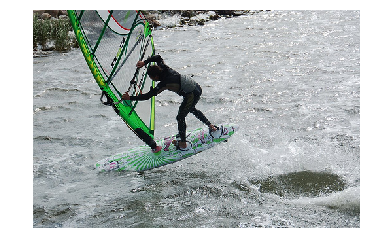

man in wetsuit is riding bike in the ocean


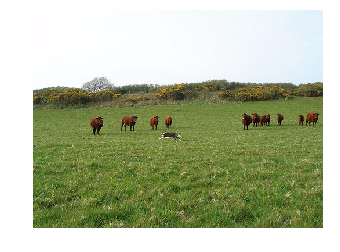

two dogs are running through field


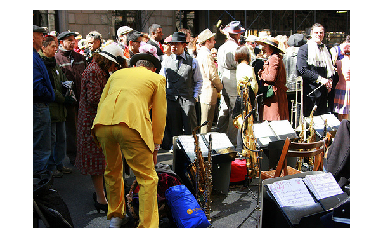

group of people are standing in line of


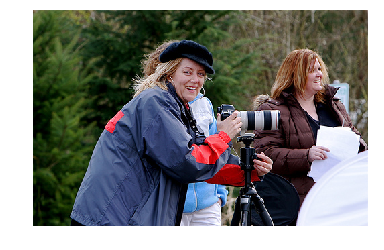

group of people are standing in front of house


In [130]:
for i in range(20,30):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread('/content/drive/My Drive/Flickr_Data.zip (Unzipped Files)/Flickr_Data/Images/'+img_name+'.jpg')
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)